<a href="https://colab.research.google.com/github/MoallaYoussef01/ExamTPF_moalla_youssef/blob/main/Train_YOLO_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sat Nov 29 12:37:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2.&nbsp;Upload Image Dataset and Prepare Training Data

upload the dataset and prepare it for training with YOLO. split the dataset into train and validation folders and generate the configuration file for training the model.

## 3 Split images into train and validation folders

In [8]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

In [10]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-11-29 12:41:51--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-11-29 12:41:51 (62.7 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Number of image files: 2755
Number of annotation files: 2755
Images moving to train: 2479
Images moving to validation: 276


# 4.&nbsp;Install Requirements (Ultralytics)

Next, we'll install the Ultralytics library in this Google Colab instance. This Python library will be used to train the YOLO model.

In [11]:
!pip install ultralytics

# 5.&nbsp;Configure Training


There's one last step before we can run training: we need to create the Ultralytics training configuration YAML file. This file specifies the location of your train and validation data, and it also defines the model's classes. An example configuration file model is available [here](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/coco128.yaml).

Run the code block below to automatically generate a `data.yaml` configuration file. Make sure you have a labelmap file located at `custom_data/classes.txt`. If you used Label Studio or one of my pre-made datasets, it should already be present. If you assembled the dataset another way, you may have to manually create the `classes.txt` file (see [here](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/doc/classes.txt) for an example of how it's formatted).

In [12]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 7
names:
- aphids
- lepidoptera
- snails
- slugs
- mites
- thrips
- whiteflies


# 6.&nbsp;Train Model

## Run Training!

In [13]:
!yolo detect train data=/content/data.yaml model=yolov8n.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj

#7.&nbsp;Test Model

In [14]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs

image 1/523 /content/data/validation/images/00000001_jpg.rf.c512f28482b0132a38872c3f03e3c00a.jpg: 640x640 1 mites, 9.8ms
image 2/523 /content/data/validation/images/00000004_jpg.rf.3aa9fb5130053110f265c4ddc8f13780.jpg: 640x640 1 mites, 7.3ms
image 3/523 /content/data/validation/images/00000005_jpg.rf.9a28a3f3ee1b17823e5dc5f76e825408.jpg: 640x640 1 mites, 7.3ms
image 4/523 /content/data/validation/images/00000009_jpg.rf.a05d2c8030aea8e41969a1d2f4e16814.jpg: 640x640 1 mites, 7.2ms
image 5/523 /content/data/validation/images/00000015_jpg.rf.ac177366a462a6132847265940267f5e.jpg: 640x640 1 mites, 7.2ms
image 6/523 /content/data/validation/images/00000020_jpeg.rf.498932a51ca7364cf5274842c78aa730.jpg: 640x640 1 mites, 7.3ms
image 7/523 /content/data/validation/images/00000021_jpg.rf.5f48aaa5ffbf638b74b9229d84386e6f.jpg: 640x640 1 m

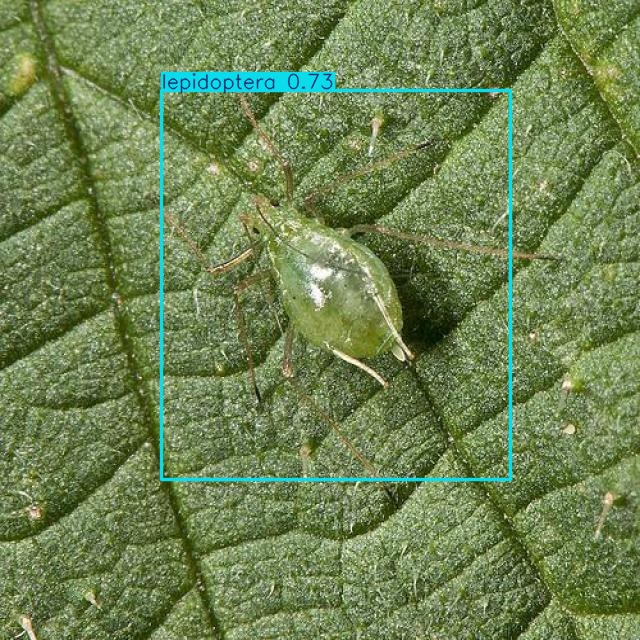

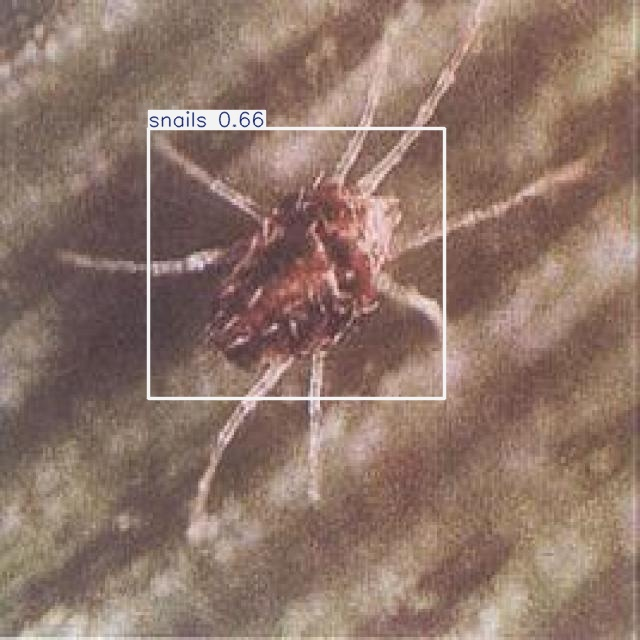

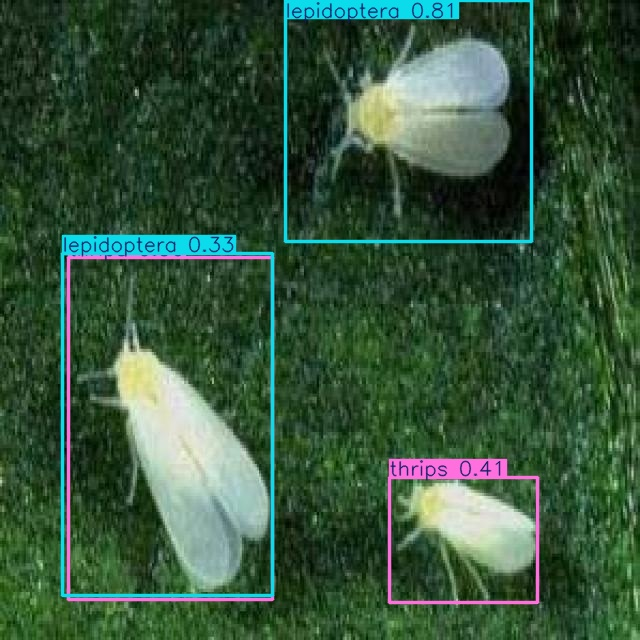

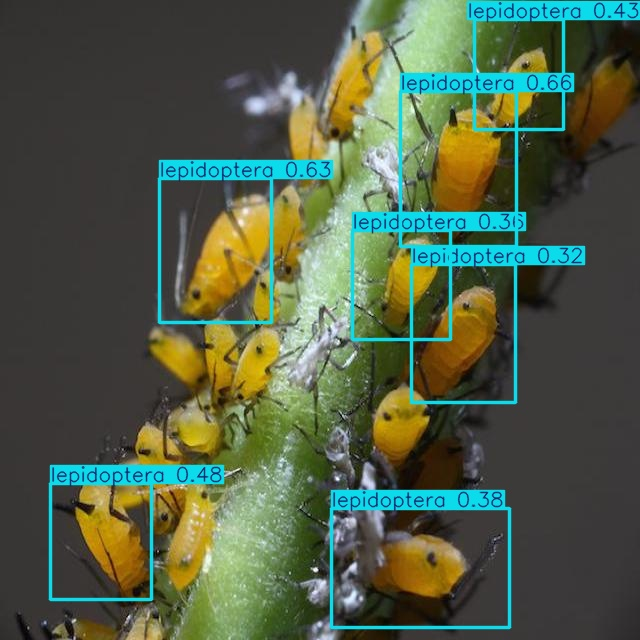

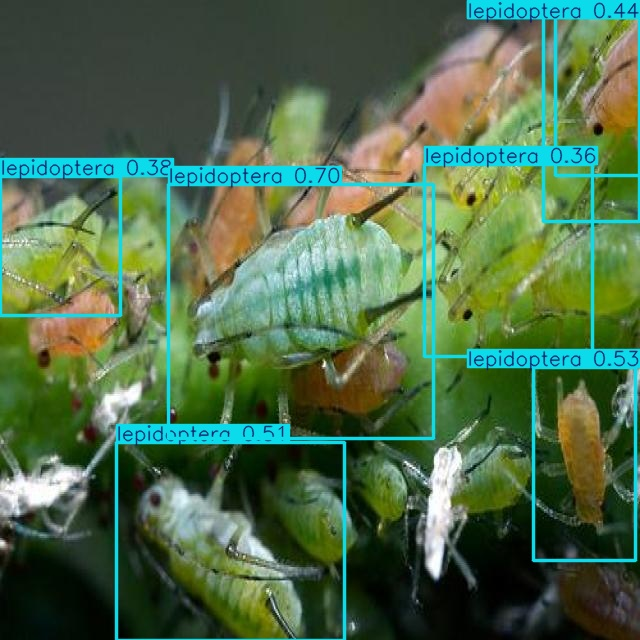

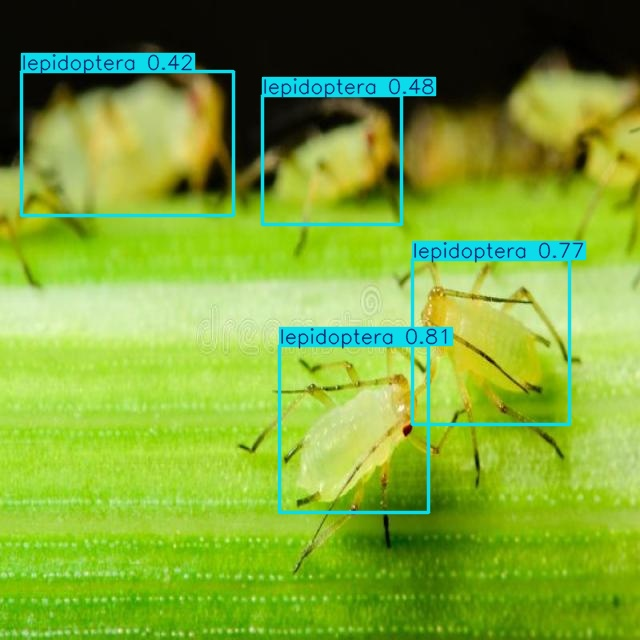

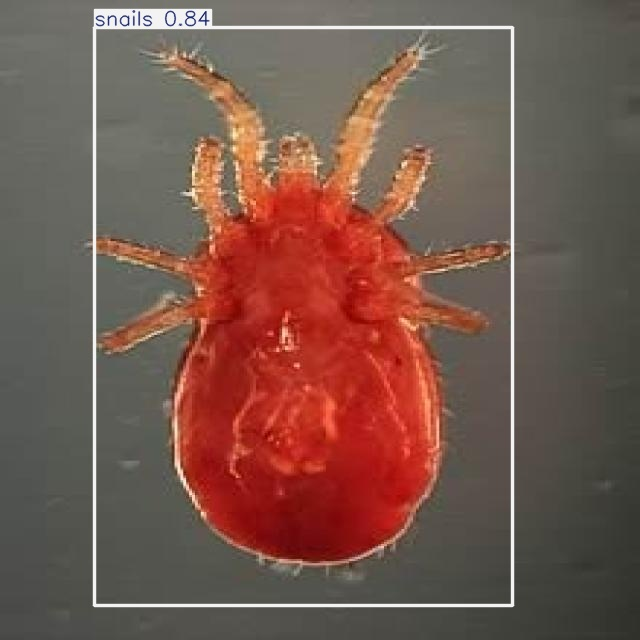

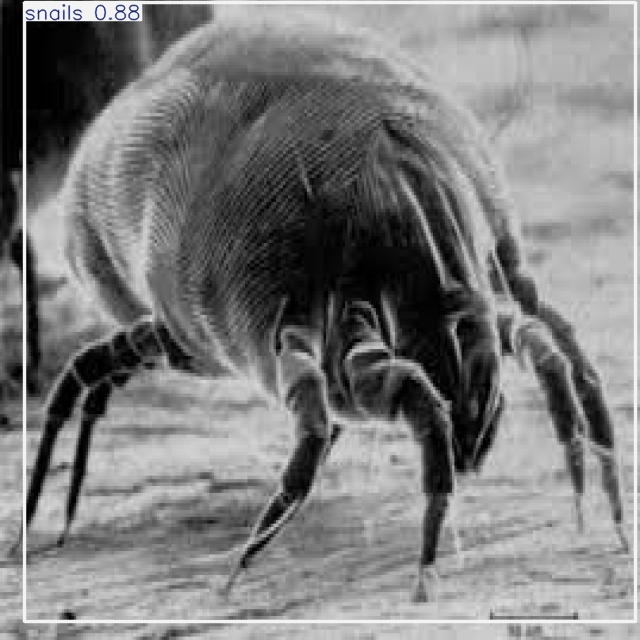

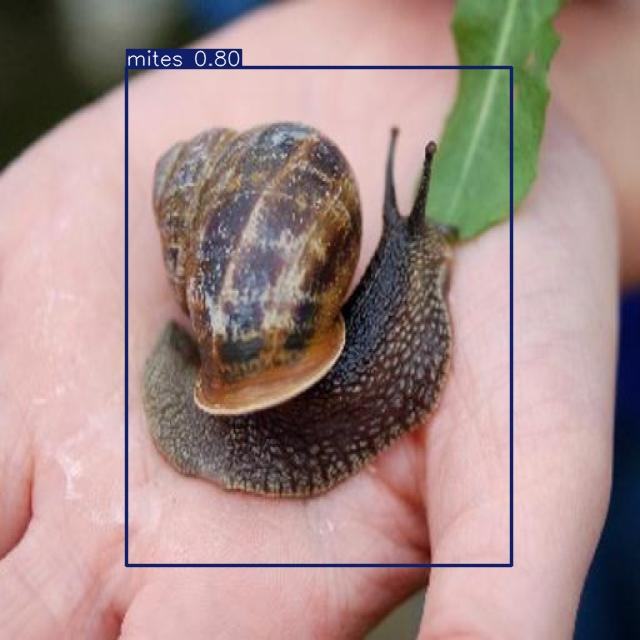

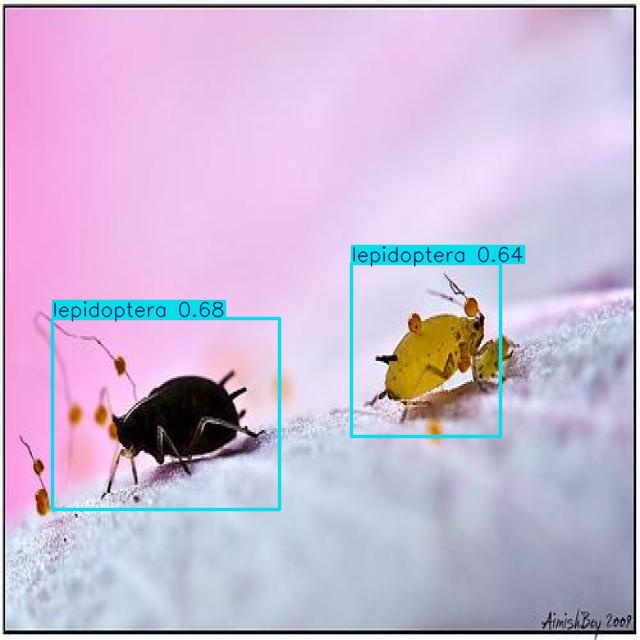

In [17]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


#7.&nbsp;Deploy Model

## 7.1 Download YOLO Model

First, zip and download the trained model by running the code blocks below.

The code creates a folder named `my_model`, moves the model weights into it, and renames them from `best.pt` to `my_model.pt`. It also adds the training results in case you want to reference them later. It then zips the folder as `my_model.zip`.

In [ ]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

In [ ]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')

## 7.2 Deploy YOLO Model on Local Devices

Next, we'll take our downloaded model and run it on a local device. This section provides instructions showing how to deploy YOLO models on various devices.

I wrote a basic Python script, `yolo_detect.py`, that shows how to load a model, run inference on an image source, parse the inference results, and display boxes around each detected class in the image. The [script](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/yolo_detect.py) gives an example of how to work with Ultralytics YOLO models in Python, and it can be used as a starting point for more advanced applications.

### 7.2.1 Deploy on PC (Windows, Linux, or macOS)

The easiest way to run Ultralytics models on a PC is using Anaconda. Anaconda sets up a virtual Python environment and allows you to easily install Ultralytics and PyTorch. It automatically installs CUDA and cuDNN, which allows you to speed up model inference with your NVIDIA GPU.

> **NOTE:** My YouTube video (link to be added) shows how to deploy your model on a PC. It walks through the following steps, so watch the video if you prefer having visual instructions.

**1. Download and Install Anaconda**

Go to the Anaconda download page at https://anaconda.com/download, click the “skip registration” button, and then download the package for your OS. When it's finished downloading, run the installer and click through the installation steps. You can use the default options for installation.

**2. Set up virtual environment**

Once it's installed, run Anaconda Prompt from the Start Bar. (If you're on macOS or Linux, just open a command terminal).

Issue the following commands to create a new Python environment and activate it:

```
conda create --name yolo-env1 python=3.12 -y
conda activate yolo-env1
```

Install Ultralytics (which also installs import libraries like OpenCV-Python, Numpy, and PyTorch) by issuing the following command:

```
pip install ultralytics
```

If you have an NVIDIA GPU, you can install the GPU-enabled version of PyTorch by issuing the following command:

```
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
```

**3. Extract downloaded model**
Take the `my_model.zip` file you downloaded in Step 7.1 and unzip it to a folder on your PC. In the Anaconda Prompt terminal, move into the unzipped folder using:

```
cd path/to/folder
```

**4. Download and run yolo_detect.py**

Download the `yolo_detect.py` script into the `my_model` folder using:

```
curl -o yolo_detect.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py
```

Alright! We're ready to run the script. To run inference with a yolov8s model on a USB camera at 1280x720 resolution, issue:

```
python yolo_detect.py --model my_model.pt --source usb0 --resolution 1280x720
```

A window will appear showing a live feed from your webcam with boxes drawn around detected objects in each frame.

You can also run the model on an video file, image, or folder of images. To see a full list of arguments for `yolo_detect.py`, issue `python yolo_detect.py --help` or see the [README file](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/README.md).




### 7.2.2 Deploy on Raspberry Pi

Keep an eye out for an article showing how to convert YOLO models to NCNN format and run them on the Raspberry Pi!

# 8.&nbsp;Conclusion

Congratulations! You've successfully trained and deployed a YOLO object detection model. 😀

Next, you can extend your application beyond just drawing boxes and counting objects. Add functionality like logging the number of objects detected over time or taking a picture when certain objects are detected. Check out some example applications at our GitHub repository: https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models

Thanks for working through this notebook, and good luck with your projects!

# Appendix: Common Errors

If you run into any errors working through this notebook, please do the following:


- Double-check that the dataset files are set up in the correct folder structure
- Make sure there are no typos or errors in your labelmap file
- Google search the error to look for solutions

If none of those help, please submit an [Issue](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/issues) on the GitHub page. In this section, I will add resolutions to common errors as they come up.